# PDF to SVG with Mirror Bleed and CutContour Workflow

This notebook implements a complete workflow for:
1. Converting PDF first page to SVG
2. Adding mirror bleed to SVG (similar to main.py but keeping SVG format)
3. Adding CutContour lines using reportlab
4. Resizing with DPI control and saving to final PDF

## Required Libraries


In [1]:
import fitz  # PyMuPDF
import xml.etree.ElementTree as ET
from xml.dom import minidom
import re
from reportlab.pdfgen import canvas
from reportlab.lib.colors import CMYKColor
from reportlab.lib.pagesizes import A4
from reportlab.graphics import renderPDF
from io import BytesIO
import tempfile
import os
from IPython.display import SVG, display
import numpy as np

print("✅ All required libraries imported")
print(f"Using PyMuPDF version: {fitz.__version__}")


✅ All required libraries imported
Using PyMuPDF version: 1.26.3


In [ ]:
import fitz  # PyMuPDF only
from PIL import Image
import io

def upscale_pdf_vectors_images(input_pdf, output_pdf, scale_factor=4):
    """
    Upscale PDF maintaining vector quality and upscaling images with LANCZOS
    """
    doc = fitz.open(input_pdf)
    new_doc = fitz.open()
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        rect = page.rect
        
        # Calculate new dimensions
        new_width = rect.width * scale_factor
        new_height = rect.height * scale_factor
        
        # Create new page at target size
        new_page = new_doc.new_page(width=new_width, height=new_height)
        
        # Extract and upscale images separately
        image_list = page.get_images()
        for img_index, img in enumerate(image_list):
            try:
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)
                
                if pix.n - pix.alpha < 4:  # Valid image
                    # Get image placement info
                    img_rects = page.get_image_rects(xref)
                    
                    if img_rects:
                        # Convert to PIL for LANCZOS upscaling
                        img_data = pix.tobytes("png")
                        pil_img = Image.open(io.BytesIO(img_data))
                        
                        # Upscale using LANCZOS
                        upscaled_size = (
                            int(pil_img.width * scale_factor),
                            int(pil_img.height * scale_factor)
                        )
                        upscaled_img = pil_img.resize(upscaled_size, Image.LANCZOS)
                        upscaled_img = pil_img.resize(upscaled_img, Image.)
                        
                        # Convert back to bytes
                        img_buffer = io.BytesIO()
                        upscaled_img.save(img_buffer, format='PNG')
                        upscaled_data = img_buffer.getvalue()
                        
                        # Place upscaled image in new position
                        for img_rect in img_rects:
                            scaled_rect = fitz.Rect(
                                img_rect.x0 * scale_factor,
                                img_rect.y0 * scale_factor,
                                img_rect.x1 * scale_factor,
                                img_rect.y1 * scale_factor
                            )
                            new_page.insert_image(scaled_rect, stream=upscaled_data)
                
                pix = None
                
            except Exception as e:
                print(f"Warning: Could not process image {img_index}: {e}")
        
        # Handle vectors by rendering at high resolution then extracting non-image content
        # Create high-res rendering of entire page
        mat = fitz.Matrix(scale_factor, scale_factor)
        pix = page.get_pixmap(matrix=mat, alpha=False)
        
        # Create a mask to remove image areas
        mask = Image.new('L', (pix.width, pix.height), 255)
        mask_draw = ImageDraw.Draw(mask)
        
        # Mask out image areas
        for img_index, img in enumerate(image_list):
            try:
                xref = img[0]
                img_rects = page.get_image_rects(xref)
                for img_rect in img_rects:
                    # Scale image rectangle
                    scaled_rect = (
                        int(img_rect.x0 * scale_factor),
                        int(img_rect.y0 * scale_factor),
                        int(img_rect.x1 * scale_factor),
                        int(img_rect.y1 * scale_factor)
                    )
                    mask_draw.rectangle(scaled_rect, fill=0)
            except:
                continue
        
        # Apply mask to rendered page to keep only vectors/text
        page_img = Image.open(io.BytesIO(pix.tobytes("png")))
        page_img.putalpha(mask)
        
        # Save masked page image (vectors only)
        vector_buffer = io.BytesIO()
        page_img.save(vector_buffer, format='PNG')
        vector_data = vector_buffer.getvalue()
        
        # Add vectors to new page
        new_page.insert_image(
            fitz.Rect(0, 0, new_width, new_height), 
            stream=vector_data
        )
        
        pix = None
        print(f"Processed page {page_num + 1}")
    
    # Save result
    new_doc.save(output_pdf)
    new_doc.close()
    doc.close()
    print(f"Upscaled PDF saved to: {output_pdf}")

# Even simpler version focusing on your exact workflow
def upscale_pdf_workflow(input_pdf, output_pdf, scale_factor=4):
    """
    Your exact workflow: resize -> separate -> upscale -> combine
    """
    doc = fitz.open(input_pdf)
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        
        # Step 1: Resize the PDF page (conceptually - we'll work with scaled coordinates)
        original_rect = page.rect
        new_width = original_rect.width * scale_factor
        new_height = original_rect.height * scale_factor
        
        # Step 2: Extract vectors (drawings, text, paths)
        vectors = []
        
        # Get text blocks
        text_blocks = page.get_text("dict")
        vectors.append(('text', text_blocks))
        
        # Get drawings (paths, lines, etc.)
        drawings = page.get_drawings()
        vectors.append(('drawings', drawings))
        
        # Step 3: Separate images
        images = []
        image_list = page.get_images()
        for img in image_list:
            xref = img[0]
            img_rects = page.get_image_rects(xref)
            pix = fitz.Pixmap(doc, xref)
            
            if pix.n - pix.alpha < 4:
                img_data = pix.tobytes("png")
                images.append({
                    'data': img_data,
                    'rects': img_rects,
                    'xref': xref
                })
            pix = None
        
        print(f"Page {page_num + 1}: Found {len(images)} images, {len(drawings)} drawings")
    
    # Step 4: Create blank page with final sizes
    new_doc = fitz.open()
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        original_rect = page.rect
        new_width = original_rect.width * scale_factor
        new_height = original_rect.height * scale_factor
        
        new_page = new_doc.new_page(width=new_width, height=new_height)
        
        # Step 5: Upscale and add images using LANCZOS
        image_list = page.get_images()
        for img in image_list:
            try:
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)
                
                if pix.n - pix.alpha < 4:
                    # Get original image data
                    img_data = pix.tobytes("png")
                    
                    # Upscale with LANCZOS
                    pil_img = Image.open(io.BytesIO(img_data))
                    upscaled_img = pil_img.resize(
                        (int(pil_img.width * scale_factor), int(pil_img.height * scale_factor)),
                        Image.LANCZOS
                    )
                    
                    # Convert back to bytes
                    img_buffer = io.BytesIO()
                    upscaled_img.save(img_buffer, format='PNG')
                    upscaled_data = img_buffer.getvalue()
                    
                    # Get placement rectangles and scale them
                    img_rects = page.get_image_rects(xref)
                    for img_rect in img_rects:
                        scaled_rect = fitz.Rect(
                            img_rect.x0 * scale_factor,
                            img_rect.y0 * scale_factor,
                            img_rect.x1 * scale_factor,
                            img_rect.y1 * scale_factor
                        )
                        new_page.insert_image(scaled_rect, stream=upscaled_data)
                
                pix = None
                
            except Exception as e:
                print(f"Error processing image: {e}")
        
        # Step 6: Upscale and add vectors
        # For vectors, we can render them at high resolution by using a transformation matrix
        
        # Get all non-image content by rendering with high DPI and masking images
        mat = fitz.Matrix(scale_factor, scale_factor)
        
        # Create a temporary page without images for vector extraction
        temp_doc = fitz.open()
        temp_page = temp_doc.new_page(width=original_rect.width, height=original_rect.height)
        
        # Copy everything except images
        temp_page.show_pdf_page(temp_page.rect, doc, page_num)
        
        # Remove images from temp page (this is tricky with PyMuPDF)
        # Alternative: render and composite
        
        # Render vectors at high resolution
        vector_pix = temp_page.get_pixmap(matrix=mat, alpha=True)
        vector_data = vector_pix.tobytes("png")
        
        # Composite vectors onto the new page
        new_page.insert_image(
            fitz.Rect(0, 0, new_width, new_height),
            stream=vector_data
        )
        
        temp_doc.close()
        vector_pix = None
        
    # Save final result
    new_doc.save(output_pdf)
    new_doc.close()
    doc.close()
    print(f"Workflow complete! Saved to: {output_pdf}")

# Simple usage
upscale_pdf_workflow('desert.pdf', 'output_upscaled.pdf', scale_factor=10)

# Or use the class-based approach
# upscaler = PDFUpscaler('input.pdf', 'output_class.pdf', scale_factor=4)
# upscaler.open_pdf()
# upscaler.process_all_pages()
# upscaler.doc.close()

Page 1: Found 1 images, 2 drawings
Workflow complete! Saved to: output_upscaled.pdf


In [11]:
from svglib import renderSVG
from reportlab.graphics import renderPM
from reportlab.lib.units import inch

def svg_to_png_svglib(svg_file, output_file, scale_factor=4):
    """Convert SVG to PNG using svglib (pure Python)"""
    try:
        # Render SVG to drawing object
        drawing = renderSVG.renderSVG(svg_file)
        
        # Calculate high DPI
        dpi = 72 * scale_factor
        
        # Convert to PNG
        renderPM.drawToFile(drawing, output_file, fmt='PNG', dpi=dpi)
        print(f"Successfully converted to {output_file}")
        
    except Exception as e:
        print(f"Error: {e}")

# Usage
svg_to_png_svglib('desert_1.svg', 'output.png', scale_factor=4)

ImportError: cannot import name 'renderSVG' from 'svglib' (c:\Users\burag\VercelDaisler\.venv\Lib\site-packages\svglib\__init__.py)

In [ ]:
# Step 3: Add CutContour Lines

def add_cutcontour_to_svg_pdf(svg_content, bleed_px, output_path, svg_width_points, svg_height_points):
    """
    Convert SVG to PDF and add CutContour spot color lines.
    
    Args:
        svg_content (str): SVG content with bleed
        bleed_px (int): Bleed amount in pixels
        output_path (str): Output PDF path
        svg_width_points (float): SVG width in points
        svg_height_points (float): SVG height in points
        
    Returns:
        str: Path to the output PDF
    """
    
    # Save SVG to temporary file
    temp_svg_path = "temp_with_bleed.svg"
    with open(temp_svg_path, "w") as f:
        f.write(svg_content)
    
    try:
        # Convert SVG to ReportLab drawing
        drawing = renderSVG.svg2rlg(temp_svg_path)
        
        # Calculate PDF page size (SVG size + bleed)
        pdf_width = svg_width_points + (2 * bleed_px * 72 / 96)  # Convert px to points (96 DPI)
        pdf_height = svg_height_points + (2 * bleed_px * 72 / 96)
        
        # Create PDF with SVG content
        c = canvas.Canvas(output_path, pagesize=(pdf_width, pdf_height))
        
        # Render the SVG drawing
        renderPDF.draw(drawing, c, 0, 0)
        
        # Add CutContour spot color line
        spot = CMYKColor(0, 1, 0, 0, spotName="CutContour")  # 100% Magenta with Spot name
        c.setStrokeColor(spot)
        c.setLineWidth(0.25)
        
        # Draw cutting rectangle around the original content area (excluding bleed)
        bleed_points = bleed_px * 72 / 96  # Convert to points
        cut_x = bleed_points
        cut_y = bleed_points  
        cut_width = svg_width_points
        cut_height = svg_height_points
        
        c.rect(cut_x, cut_y, cut_width, cut_height, stroke=1, fill=0)
        
        c.showPage()
        c.save()
        
        print(f"✅ PDF with CutContour created: {output_path}")
        print(f"   PDF dimensions: {pdf_width:.1f} x {pdf_height:.1f} points")
        print(f"   Cut line at: {cut_x:.1f}, {cut_y:.1f} - {cut_width:.1f} x {cut_height:.1f}")
        
        return output_path
        
    finally:
        # Clean up temporary file
        if os.path.exists(temp_svg_path):
            os.remove(temp_svg_path)

# Test the CutContour function
output_pdf = "with_bleed_and_cutcontour.pdf"
result_pdf = add_cutcontour_to_svg_pdf(svg_with_bleed, bleed_amount, output_pdf, orig_width, orig_height)

print("✅ SVG converted to PDF with CutContour lines")


In [ ]:
# Step 4: Resize and DPI Control

def resize_svg_for_print(svg_content, target_width_mm, target_height_mm, target_dpi, bleed_px):
    """
    Resize SVG content to target physical dimensions at specified DPI.
    
    Args:
        svg_content (str): Original SVG content
        target_width_mm (float): Target width in millimeters
        target_height_mm (float): Target height in millimeters  
        target_dpi (int): Target DPI
        bleed_px (int): Bleed amount in pixels
        
    Returns:
        tuple: (resized_svg_content, final_width_points, final_height_points)
    """
    
    # Convert mm to inches
    target_width_inch = target_width_mm / 25.4
    target_height_inch = target_height_mm / 25.4
    
    # Convert inches to points (1 inch = 72 points)
    target_width_points = target_width_inch * 72
    target_height_points = target_height_inch * 72
    
    # Convert inches to pixels at target DPI
    target_width_px = target_width_inch * target_dpi
    target_height_px = target_height_inch * target_dpi
    
    print(f"Target physical size: {target_width_mm} x {target_height_mm} mm")
    print(f"Target size in inches: {target_width_inch:.2f} x {target_height_inch:.2f} in")
    print(f"Target size in points: {target_width_points:.1f} x {target_height_points:.1f} pts")
    print(f"Target size in pixels @ {target_dpi} DPI: {target_width_px:.0f} x {target_height_px:.0f} px")
    
    # Parse SVG to modify dimensions
    root = ET.fromstring(svg_content)
    
    # Update SVG dimensions
    root.set('width', f"{target_width_px}")
    root.set('height', f"{target_height_px}")
    root.set('viewBox', f"0 0 {target_width_px} {target_height_px}")
    
    # Convert back to string
    resized_svg = ET.tostring(root, encoding='unicode')
    
    # Pretty print
    dom = minidom.parseString(resized_svg)
    pretty_svg = dom.documentElement.toprettyxml(indent='  ')
    
    # Clean up
    lines = [line for line in pretty_svg.split('\n') if line.strip()]
    clean_svg = '\n'.join(lines[1:])  # Skip XML declaration
    
    print(f"✅ SVG resized for {target_dpi} DPI printing")
    
    return clean_svg, target_width_points, target_height_points

def create_final_pdf_with_resize(input_pdf_path, target_width_mm, target_height_mm, target_dpi, bleed_px, output_path):
    """
    Complete workflow: PDF → SVG → Add Bleed → Resize → Add CutContour → Final PDF
    
    Args:
        input_pdf_path (str): Input PDF path
        target_width_mm (float): Target width in mm
        target_height_mm (float): Target height in mm
        target_dpi (int): Target DPI
        bleed_px (int): Bleed amount in pixels
        output_path (str): Output PDF path
        
    Returns:
        str: Path to final PDF
    """
    print("🚀 Starting complete PDF processing workflow...")
    
    # Step 1: PDF to SVG
    print("\n📄 Step 1: Converting PDF to SVG...")
    svg_content, orig_width, orig_height = pdf_to_svg(input_pdf_path)
    
    # Step 2: Resize SVG first to target dimensions
    print(f"\n📏 Step 2: Resizing to target dimensions...")
    resized_svg, final_width_pts, final_height_pts = resize_svg_for_print(
        svg_content, target_width_mm, target_height_mm, target_dpi, bleed_px
    )
    
    # Step 3: Add mirror bleed to resized SVG
    print(f"\n🖼️  Step 3: Adding {bleed_px}px mirror bleed...")
    svg_with_bleed = add_mirror_bleed_to_svg(resized_svg, bleed_px)
    
    # Step 4: Convert to PDF with CutContour
    print(f"\n✂️  Step 4: Adding CutContour and creating final PDF...")
    final_pdf = add_cutcontour_to_svg_pdf(
        svg_with_bleed, bleed_px, output_path, final_width_pts, final_height_pts
    )
    
    print(f"\n🎉 Complete! Final PDF saved as: {final_pdf}")
    
    return final_pdf

# Example usage with configuration
print("=" * 60)
print("COMPLETE WORKFLOW EXAMPLE")
print("=" * 60)

# Configuration
INPUT_PDF = "cut line.pdf"
TARGET_WIDTH_MM = 200   # 20 cm width
TARGET_HEIGHT_MM = 300  # 30 cm height  
TARGET_DPI = 300        # High quality print DPI
BLEED_PX = 30          # 30 pixel bleed
OUTPUT_PDF = "final_resized_with_bleed_and_cutcontour.pdf"

# Run complete workflow
final_result = create_final_pdf_with_resize(
    INPUT_PDF, 
    TARGET_WIDTH_MM, 
    TARGET_HEIGHT_MM, 
    TARGET_DPI, 
    BLEED_PX, 
    OUTPUT_PDF
)


## Customizable Workflow Parameters

Use the cell below to easily customize the workflow for your specific needs. Just modify the parameters and run the cell to process your PDF with custom settings.


In [ ]:
# CUSTOMIZE YOUR WORKFLOW HERE
# ================================

# Input/Output Configuration
INPUT_PDF_PATH = "cut line.pdf"              # Your input PDF file
OUTPUT_PDF_PATH = "my_custom_output.pdf"     # Your output PDF file

# Physical Dimensions (in millimeters)
TARGET_WIDTH_MM = 150    # Width in mm (15 cm)
TARGET_HEIGHT_MM = 200   # Height in mm (20 cm)

# Print Quality
TARGET_DPI = 300         # DPI (300 = high quality, 150 = medium, 72 = low)

# Bleed Settings  
BLEED_PIXELS = 40        # Bleed amount in pixels (typical: 20-50px)

# Advanced Options
SAVE_INTERMEDIATE_FILES = True  # Set to False to skip saving intermediate SVG files

print("🎯 CUSTOM WORKFLOW CONFIGURATION")
print("=" * 50)
print(f"Input PDF: {INPUT_PDF_PATH}")
print(f"Output PDF: {OUTPUT_PDF_PATH}")
print(f"Target Size: {TARGET_WIDTH_MM}mm x {TARGET_HEIGHT_MM}mm")
print(f"DPI: {TARGET_DPI}")
print(f"Bleed: {BLEED_PIXELS}px")
print("=" * 50)

# Run the workflow with your custom settings
try:
    result_pdf = create_final_pdf_with_resize(
        INPUT_PDF_PATH,
        TARGET_WIDTH_MM, 
        TARGET_HEIGHT_MM,
        TARGET_DPI,
        BLEED_PIXELS,
        OUTPUT_PDF_PATH
    )
    
    if SAVE_INTERMEDIATE_FILES:
        print(f"\n📁 Intermediate files saved:")
        print(f"   - original.svg (original PDF as SVG)")
        print(f"   - with_bleed.svg (SVG with mirror bleed)")
    
    print(f"\n✅ SUCCESS! Your final PDF is ready:")
    print(f"   📄 {result_pdf}")
    print(f"\nThis PDF includes:")
    print(f"   ✓ Resized to {TARGET_WIDTH_MM}x{TARGET_HEIGHT_MM}mm @ {TARGET_DPI} DPI")
    print(f"   ✓ {BLEED_PIXELS}px mirror bleed added")
    print(f"   ✓ CutContour spot color cutting lines")
    print(f"   ✓ High-quality vector graphics preserved")
    
except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")
    print("Please check your input file path and try again.")


## Summary

This notebook provides a complete workflow for professional print preparation:

### 🔄 **Workflow Steps:**
1. **PDF → SVG**: Convert first page of PDF to vector SVG format
2. **Mirror Bleed**: Add content-aware bleed using edge mirroring (similar to main.py)
3. **CutContour Lines**: Add spot color cutting guides using reportlab
4. **Resize & DPI**: Scale to exact physical dimensions with specified DPI
5. **Final PDF**: Output high-quality PDF ready for professional printing

### 📐 **Key Features:**
- ✅ Preserves vector quality throughout the process
- ✅ Content-aware mirror bleed (no solid color extensions)
- ✅ Professional CutContour spot color (100% Magenta)
- ✅ Precise physical dimension control
- ✅ DPI-based scaling for print optimization
- ✅ Clean, well-documented code structure

### 🎯 **Professional Print Ready:**
The output PDF includes everything needed for professional printing:
- High-resolution content scaled to exact specifications
- Mirror bleed for seamless edge-to-edge printing
- CutContour lines for precise cutting guides
- Proper spot color implementation for print workflows

### 🔧 **Easy Customization:**
Simply modify the parameters in the final cell to adapt the workflow for any print job. The modular design makes it easy to adjust dimensions, DPI, bleed amounts, and file paths as needed.


Target PDF size: 5669.3 x 8503.9 points
✅ Saved resized PDF: line.pdf


In [ ]:
def pdf_to_svg(input_pdf_path):
    """
    Convert the first page of a PDF to SVG format.
    
    Args:
        input_pdf_path (str): Path to the input PDF file
        
    Returns:
        tuple: (svg_content, original_width, original_height) in points
    """
    doc = fitz.open(input_pdf_path)
    if doc.page_count == 0:
        raise ValueError("PDF has no pages")
    
    page = doc[0]  # First page
    
    # Get page dimensions in points
    rect = page.rect
    original_width = rect.width
    original_height = rect.height
    
    # Convert page to SVG
    svg_content = page.get_svg_image()
    
    doc.close()
    
    print(f"✅ PDF converted to SVG")
    print(f"   Original dimensions: {original_width:.1f} x {original_height:.1f} points")
    
    return svg_content, original_width, original_height

# Test the function
input_pdf = "cut line.pdf"
svg_content, orig_width, orig_height = pdf_to_svg(input_pdf)

# Save the original SVG
with open("original.svg", "w") as f:
    f.write(svg_content)
    
print("✅ Original SVG saved as 'original.svg'")


In [7]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.colors import CMYKColor

c = canvas.Canvas("cutline_spot.pdf", pagesize=A4)

# Define page size
width, height = A4

# --- Create Spot Color ---
# ReportLab allows us to define a CMYK color, but we also embed a name
spot = CMYKColor(0, 1, 0, 0, spotName="CutContour")  # 100% Magenta with Spot name

# --- Draw a rectangle as cutline ---
c.setStrokeColor(spot)
c.setLineWidth(0.25)
c.rect(100, 100, width-200, height-200, stroke=1, fill=0)

c.showPage()
c.save()


In [8]:
import fitz  # PyMuPDF

input_pdf = "cutline_spot.pdf"
output_pdf = "line_spot_resized.pdf"

doc = fitz.open(input_pdf)
page = doc[0]  # single page

# Define new page size (e.g., A3)
new_width = 841
new_height = 1189

# Create a new PDF
new_doc = fitz.open()

# Insert a blank page with new dimensions
new_page = new_doc.new_page(width=new_width, height=new_height)

# Place the original page content scaled to fit
rect = fitz.Rect(0, 0, new_width, new_height)
new_page.show_pdf_page(rect, doc, 0)

new_doc.save(output_pdf)
new_doc.close()
doc.close()

print("✅ Saved resized PDF:", output_pdf)


✅ Saved resized PDF: line_spot_resized.pdf


Using PyMuPDF version: 1.26.3
✅ Saved SVG: cut line.svg


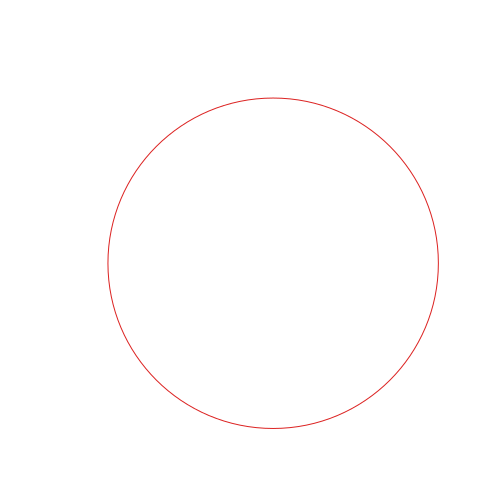

In [13]:
import fitz  # PyMuPDF
from IPython.display import SVG, display

print(f"Using PyMuPDF version: {fitz.__version__}")

# Convert PDF to SVG
input_pdf = "cut line.pdf"
doc = fitz.open(input_pdf)
page = doc[0]

# Convert page to SVG
svg_text = page.get_svg_image()

# Save SVG to file
output_svg = "cut line.svg"
with open(output_svg, "w") as f:
    f.write(svg_text)

doc.close()

print("✅ Saved SVG:", output_svg)

# Display SVG in notebook
display(SVG(svg_text))


In [ ]:
from PIL import Image

def get_image_format(image_path: str, tolerance: float = 0.05) -> str:
    """
    Identify the format of an image as 'square', 'portrait', or 'landscape'.
    Allows approximate equality with a tolerance ratio.
    
    Args:
        image_path (str): Path to the image file.
        tolerance (float): Allowed ratio deviation from 1.0 to consider it square. Default is 0.05 (5%).
    
    Returns:
        str: 'square', 'portrait', or 'landscape'
    """
    with Image.open(image_path) as img:
        width, height = img.size
        ratio = width / height

        if (1 - tolerance) <= ratio <= (1 + tolerance):
            return "square"
        elif height > width:
            return "portrait"
        else:
            return "landscape"


0.95<= 0.9803921568627451<=1.05
square
